##  Congratulations, you are now hired as a sport analytic. Your job is to give prediciton for the next Mathball tournament of the Six finest mathematicians in the world, which is a competition between Laplace, Gauss, Newton, Euler, Leibniz, Von-Neumann.

## The mathball is just like football where a player a goal is legal only after scoring you answer correctly a math question.

## Motivation:  
### We want to infer a latent parameter - that is the 'strength' of a mathematician based only on their **scoring intensity**, and all we have are their scores and results, we can't accurately measure the 'strength' of a team.


In [ ]:
# imports
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import pickle as pkl

## The input   looks like as follows:

In [ ]:

group = 4
# url = f'https://github.com/doringber1996/bayesian-model/raw/main/mathball_data_group_{group}.pkl'
url = f"https://raw.githubusercontent.com/aviya-gmara/model-bayesian/main/mathball_data_group_{group}.pkl"
df_all = pd.read_pickle(url)
df_all.head()


,home_player,away_player,home_score,away_score,year
0,Gauss,Newton,11,52,1897
1,Gauss,Von-Neumann,20,21,1897
2,Euler,Laplace,27,6,1897
3,Euler,Von-Neumann,53,3,1897
4,Newton,Euler,30,18,1897


In [ ]:
df_all.shape

(60, 5)

In [ ]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   home_player  60 non-null     object
 1   away_player  60 non-null     object
 2   home_score   60 non-null     int64 
 3   away_score   60 non-null     int64 
 4   year         60 non-null     int64 
dtypes: int64(3), object(2)
memory usage: 2.5+ KB


## We have home and away team, we have score and year.

## What do we want to infer?

### We want to infer the latent parameters (every mathematian's strength) that are generating the data we observe (the scorelines).
### Moreover, we know that the scorelines are a noisy measurement of team strength, so ideally, we want a model that makes it easy to quantify our uncertainty about the underlying strengths.

## What do we want?

### We want to quantify our uncertainty
### We want to also use this to generate a model
### We want the answers as distributions not point estimates

## Part 1

### We next do some exploratory data analysis. The idea is to get a general sense of what is going on.

## Tasks

### 1. Plot a bar chart of the goal difference (i.e., total scored minus total scored against) per mathematician. Who is the best mathematician and who is the worst according to this plot?


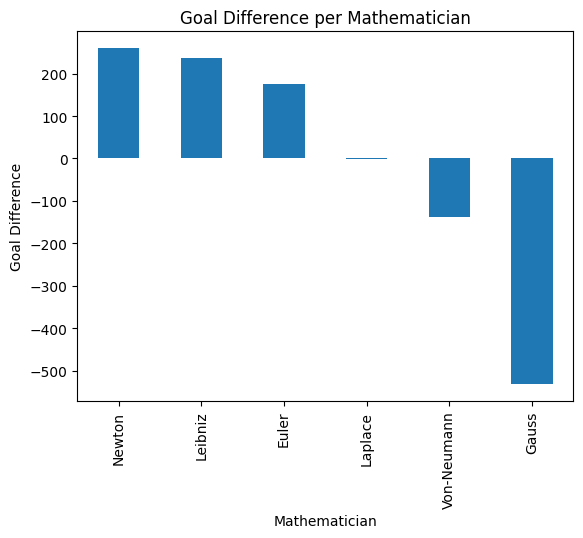

In [ ]:
df_all['home_goal_diff'] = df_all['home_score'] - df_all['away_score']
df_all['away_goal_diff'] = df_all['away_score'] - df_all['home_score']

goal_diff = df_all.groupby('home_player')['home_goal_diff'].sum() + df_all.groupby('away_player')['away_goal_diff'].sum()
goal_diff = goal_diff.sort_values(ascending=False)

# גרף עמודות של ההבדל בשערים לכל מתמטיקאי
goal_diff.plot(kind='bar')
plt.title('Goal Difference per Mathematician')
plt.ylabel('Goal Difference')
plt.xlabel('Mathematician')
plt.show()


### Conclusion

Based on the analysis of goal differences for each mathematician:

- **Best Mathematician**: Newton, with the highest positive goal difference.
- **Worst Mathematician**: Gauss, with the most negative goal difference.

The bar chart illustrates these differences clearly, showing that Newton consistently scored more goals than his opponents, while Gauss had the poorest performance in terms of goal differences. This visualization provides a straightforward comparison of each mathematician's performance.

### 2. Plot the same bar chart for each mathematician  as a function of time. Do you see a monote behvaoir which implies an improvement or the other way around for one of mathematician?

### Analysis of Goal Differences Over Time

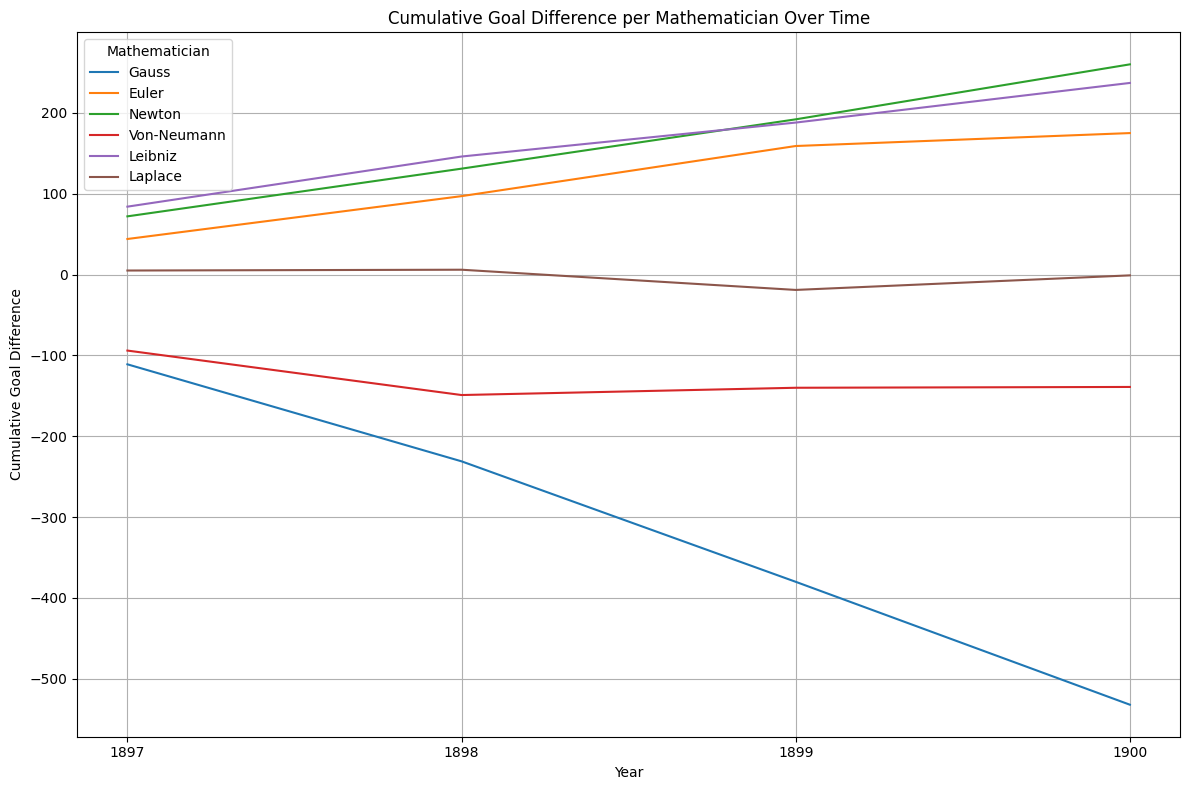

In [ ]:
# Plot goal difference for each mathematician over time
fig, ax = plt.subplots(figsize=(12, 8))

# Iterate through each unique player and plot their goal difference over time
for player in pd.concat([df_all['home_player'], df_all['away_player']]).unique():
    # Calculate home goal difference per year
    player_home_diff = df_all[df_all['home_player'] == player].groupby('year')['home_goal_diff'].sum()
    # Calculate away goal difference per year
    player_away_diff = df_all[df_all['away_player'] == player].groupby('year')['away_goal_diff'].sum()
    # Combine home and away goal differences and calculate cumulative sum
    total_diff = player_home_diff.add(player_away_diff, fill_value=0).cumsum()
    # Plot the cumulative goal difference
    total_diff.plot(ax=ax, label=player)

# Set the title and labels
ax.set_title('Cumulative Goal Difference per Mathematician Over Time')
ax.set_xlabel('Year')
ax.set_ylabel('Cumulative Goal Difference')

# Set x-ticks to be only the full years
ax.set_xticks(df_all['year'].unique())
ax.set_xticklabels(df_all['year'].unique())

# Add legend and grid
ax.legend(title='Mathematician')
ax.grid(True)

# Display the plot
plt.tight_layout()
plt.show()


#### **Cumulative Goal Difference Chart**

The first chart shows the cumulative goal difference for each mathematician over time. This chart helps to visualize the overall performance of each mathematician throughout the period. By accumulating the goal differences, we can identify long-term trends and see which mathematicians have consistently improved or deteriorated in their performance.

- **Improvement**: Mathematicians such as Newton and Euler show a clear upward trend in their cumulative goal differences, indicating consistent improvement over the years.
- **Deterioration**: Gauss exhibits a significant downward trend, suggesting a consistent decline in performance.

This chart provides a broad overview and helps us identify who maintained steady performance and who experienced significant changes over time.

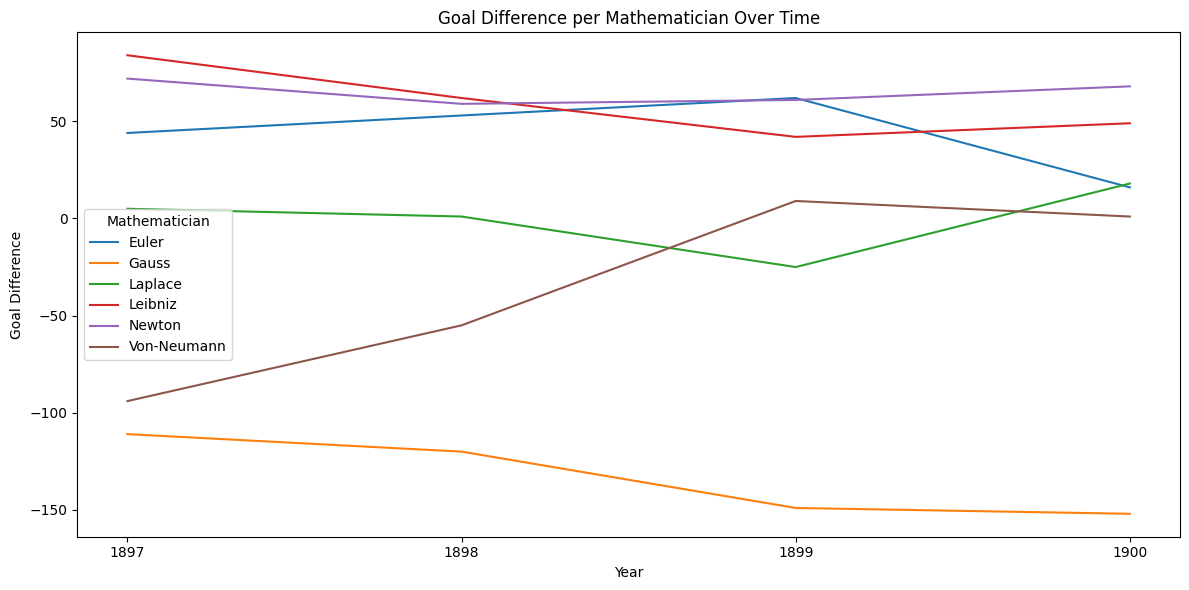

In [ ]:
# Calculate goal difference over time for home and away players
goal_diff_time_home = df_all.groupby(['home_player', 'year'])['home_goal_diff'].sum().reset_index()
goal_diff_time_home.rename(columns={'home_player': 'player', 'home_goal_diff': 'goal_diff'}, inplace=True)
goal_diff_time_away = df_all.groupby(['away_player', 'year'])['away_goal_diff'].sum().reset_index()
goal_diff_time_away.rename(columns={'away_player': 'player', 'away_goal_diff': 'goal_diff'}, inplace=True)

# Combine home and away goal differences
goal_diff_time = pd.concat([goal_diff_time_home, goal_diff_time_away])
goal_diff_time = goal_diff_time.groupby(['player', 'year'])['goal_diff'].sum().reset_index()

# Create the line plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=goal_diff_time, x='year', y='goal_diff', hue='player')
plt.title('Goal Difference per Mathematician Over Time')
plt.ylabel('Goal Difference')
plt.xlabel('Year')
plt.legend(title='Mathematician')

# Set x-ticks to be only the full years
plt.xticks(df_all['year'].unique())

# Display the plot
plt.tight_layout()
plt.show()


#### **Yearly Goal Difference Chart**

The second chart focuses on the goal difference for each year individually. This visualization allows us to see the performance fluctuations on a year-by-year basis, providing insights into the annual performance of each mathematician.

- **Annual Trends**: By looking at the yearly goal differences, we can identify specific years where a mathematician performed exceptionally well or poorly. For instance, we can see if there are any spikes or drops that indicate particular events or conditions affecting their performance.
- **Detailed Analysis**: This chart complements the cumulative chart by breaking down the overall trends into more granular yearly data. It helps to understand whether the cumulative trends are due to steady performance each year or if there are significant variations year by year.

Together, these charts provide a comprehensive view of the mathematicians' performances over time, helping us to understand both the long-term trends and the annual variations in their goal differences.

#### Performance Improvement and Decline

- **Newton**: Shows a steady improvement over the years, with cumulative goal differences increasing year by year.
- **Euler**: Also shows improvement, though with a more gradual slope compared to Newton.
- **Gauss**: Demonstrates a continuous decline in performance, with a significant negative trend in the cumulative goal differences.
- **Von-Neumann**: Although maintaining a relatively flat performance initially, starts to show a decline around the year 1898.
- **Laplace**: Shows some variability, with performance improving in some years and declining in others, indicating inconsistent performance.
- **Leibniz**: Shows a relatively stable performance, with minor fluctuations year by year.

These observations help us understand which mathematicians are improving, remaining stable, or declining in their performance, and identify the specific years when significant changes occurred.

----

### 3. Choose your favorite mathematician, compare the goal difference between home and away games. Is he better in home or away games? Plot a bar chart of the goal difference for both home and away games.

<ipython-input-54-1aa176296809>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=newton_diff, x='Game Type', y='Goal Difference', palette='viridis')


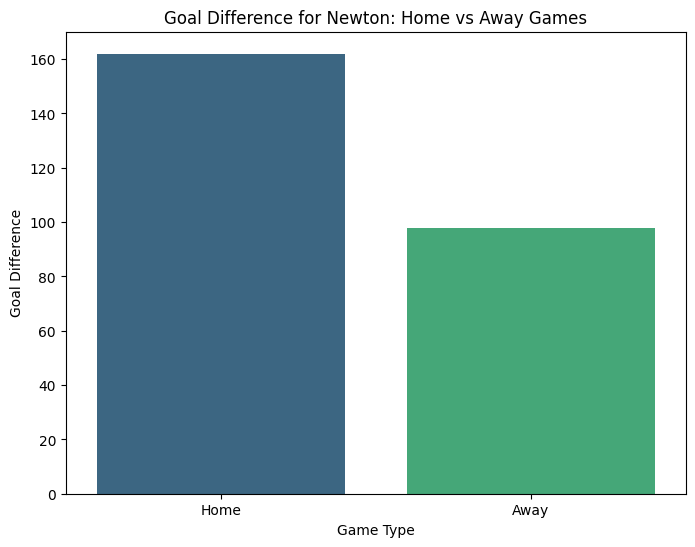

In [ ]:
# Filter data for Newton
newton_home = df_all[df_all['home_player'] == 'Newton']
newton_away = df_all[df_all['away_player'] == 'Newton']

# Calculate total goal difference for home and away games
newton_home_diff = newton_home['home_goal_diff'].sum()
newton_away_diff = newton_away['away_goal_diff'].sum()

# Create a DataFrame for plotting
newton_diff = pd.DataFrame({
    'Game Type': ['Home', 'Away'],
    'Goal Difference': [newton_home_diff, newton_away_diff]
})

# Plot the bar chart
plt.figure(figsize=(8, 6))
sns.barplot(data=newton_diff, x='Game Type', y='Goal Difference', palette='viridis')
plt.title('Goal Difference for Newton: Home vs Away Games')
plt.ylabel('Goal Difference')
plt.xlabel('Game Type')
plt.show()

### Goal Difference for Newton: Home vs Away Games

The bar chart above compares the goal difference for `Newton` in home and away games. The results indicate the following:

- **Home Games**: `Newton` has a goal difference of 162.
- **Away Games**: `Newton` has a goal difference of 98.

Based on these results, Newton performs better in home games compared to away games, with a significantly higher goal difference when playing at home.

---

### 4. Which mathematician has the best median away results? (that is, for each mathematician go over all of his away games, compute his scoring difference (how much he scored minues got scored against) and compute the median value).

<ipython-input-55-5d6d0d59ed40>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=median_away_diff_df, x='Mathematician', y='Median Goal Difference', palette='viridis')


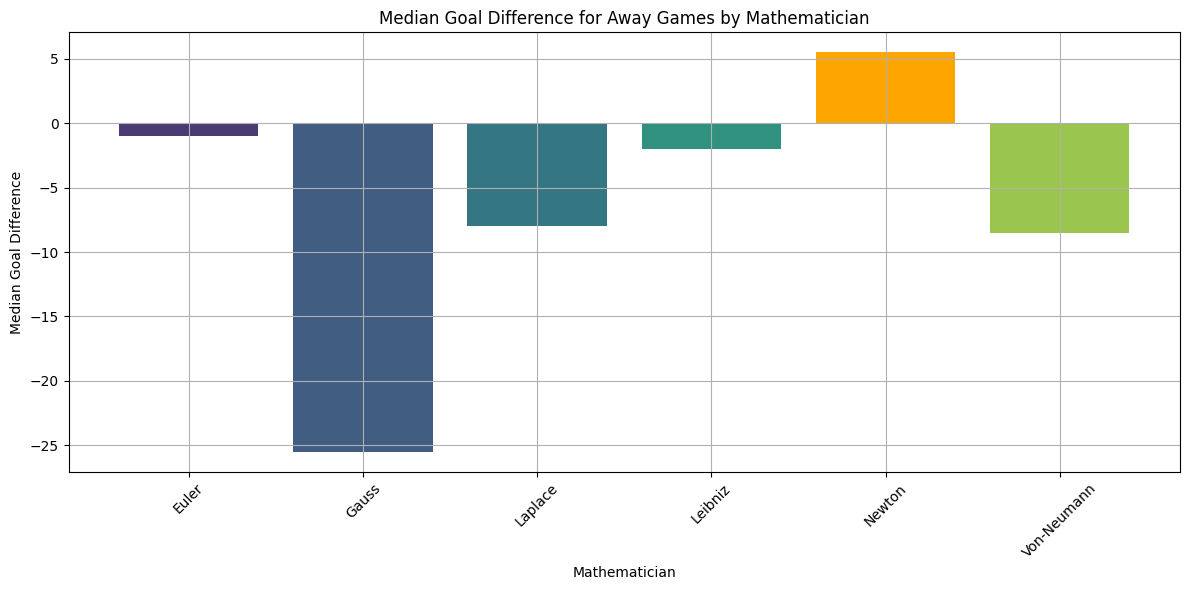

In [ ]:
# חישוב ההבדל בשערים במשחקי חוץ
df_all['away_goal_diff'] = df_all['away_score'] - df_all['home_score']

# חישוב החציון של ההבדל בשערים במשחקי חוץ עבור כל מתמטיקאי
median_away_results = df_all.groupby('away_player')['away_goal_diff'].median()


# Create a DataFrame for plotting the median goal differences for away games
median_away_diff_df = median_away_results.reset_index() # Use median_away_results instead of median_away_diff
median_away_diff_df.columns = ['Mathematician', 'Median Goal Difference']

# Plot the bar chart
plt.figure(figsize=(12, 6))
sns.barplot(data=median_away_diff_df, x='Mathematician', y='Median Goal Difference', palette='viridis')
plt.title('Median Goal Difference for Away Games by Mathematician')
plt.ylabel('Median Goal Difference')
plt.xlabel('Mathematician')
plt.xticks(rotation=45)
plt.grid(True)

# Highlight the best median away result
best_index = median_away_diff_df['Mathematician'] == best_median_away
plt.bar(median_away_diff_df[best_index]['Mathematician'], median_away_diff_df[best_index]['Median Goal Difference'], color='orange')

plt.tight_layout()
plt.show()

In [ ]:
# חישוב ההבדל בשערים במשחקי חוץ
df_all['away_goal_diff'] = df_all['away_score'] - df_all['home_score']

# חישוב החציון של ההבדל בשערים במשחקי חוץ עבור כל מתמטיקאי
median_away_results = df_all.groupby('away_player')['away_goal_diff'].median()

# מציאת המתמטיקאי עם החציון הגבוה ביותר
best_median_away = median_away_results.idxmax()
best_median_value = median_away_results.max()

print(f'The mathematician with the best median away results is {best_median_away} with a median goal difference of {best_median_value:.2f}')

The mathematician with the best median away results is Newton with a median goal difference of 5.50


## Part 2

## What assumptions do we know for our mathball competition?

### We know that there are 6 mathematicians, each year all possible pairs playes once.  
### We have data from the last few years
### We also know that in sports scoring is modelled as a Poisson distribution (even in mathball)
### We consider home advantage to be a strong effect in sports

## The model.

### The league is made up by a total of T= 6 mathematicians, playing each other once in a season.

### We indicate the number of goals scored by the home and the away player in the g-th game of the season (15 games) as $y_{g1}$ and $y_{g2}$ respectively. </p>
### The vector of observed goal counts $\mathbb{y} = (y_{g1}, y_{g2})$ is modelled as independent Poisson:
## $$y_{gj}| \theta_{gj} \tilde\;\;  Poisson(\theta_{gj})$$
### where the theta parameters represent the scoring intensity in the g-th game for the team playing at home (j=1) and away (j=2), respectively.</p>

## We model these parameters according to a formulation that has been used widely in the statistical literature, assuming a log-linear random effect model:
### $$ log \theta_{g1} = intercept + home + \hat{att}_{h(g)} + \hat{def}_{a(g)} $$
### $$ log \theta_{g2} = intercept + \hat{att}_{a(g)} + \hat{def}_{h(g)}$$


## Alternitevly:

### $$  \theta_{g1} = e^{intercept + home + \hat{att}_{h(g)} + \hat{def}_{a(g)}} $$
### $$  \theta_{g2} = e^{intercept + \hat{att}_{a(g)} + \hat{def}_{h(g)}}$$

### $\hat{att}_{h(g)}$ is the attack effect of a player.
### $\hat{def}_{h(g)}$ is the defense effect of a player.

### For mathematician  i = 1, ..., 6, both  $\hat{att}_{i}$ and $\hat{def}_{i}$ are normalized values, fomrally:

### $$ \hat{att}_{i} = att_i - \bar{att} $$
### $$ \hat{def}_{i} = def_i - \bar{def} $$

where,

### $$ \bar{att}  = \frac{\sum_{i=1}^6 att_i}{6} $$
### $$ \bar{def}  = \frac{\sum_{i=1}^6 def_i}{6} $$

### Just for clarification: suppose we index mathematicians as follows:
### 1: Laplace
### 2: Gauss
### 3: Newton
### 4: Euler
### 5: Leibniz
### 6: Von-Neumann

### Now, suppose the first game is Laplace hosting Gauss (the clash of the titans).
### Thus, $h(1) = 1 $ (i.e.,Laplace ) and $a(1) = 2 $ (i.e., Gauss).

### The parameter home represents the advantage for the team hosting the game and we assume that this effect is constant for all the teams and throughout the season
### The scoring intensity is determined jointly by the attack and defense ability of the two teams involved, represented by the parameters att and def, respectively

### Conversely, for each i = 1, ..., 6, the player-specific effects are modelled as exchangeable from a common distribution:

### $att_{i} \; \tilde\;\; Normal(0,\tau_{att})$ and $def_{i} \; \tilde\;\;Normal(0,\tau_{def})$

### The log function to away scores and home scores is a standard trick in the sports analytics literature

## Tasks

### 1. Build a Hierarchical model with PyMc where you obtain a posterior of the latent variables: $home$, $att_i$,  $def_i$ for $i = \{1,2,3,4,5,6\} $ and $intercept$.
### Remark: Set the MCMC configuration regarding the number of draws, such that there will 4000 samples in total.



## guidence:
###  For the Hierarchical model, connect the different players (mathematicians) only via the attack and defence std (i.e., $\tau_{att}$ and $\tau_{def}$) and not the mean value.

## Indexing the data for the pymc model

In [ ]:
import numpy as np

In [ ]:
df_all.head()

,home_player,away_player,home_score,away_score,year,home_goal_diff,away_goal_diff
0,Gauss,Newton,11,52,1897,-41,41
1,Gauss,Von-Neumann,20,21,1897,-1,1
2,Euler,Laplace,27,6,1897,21,-21
3,Euler,Von-Neumann,53,3,1897,50,-50
4,Newton,Euler,30,18,1897,12,-12


In [ ]:
## for your convinience we have here the home and away index with respect to df_all.
home_idx, teams = pd.factorize(df_all["home_player"], sort=True)
away_idx, _ = pd.factorize(df_all["away_player"], sort=True)


In [ ]:
df_all.head()

,home_player,away_player,home_score,away_score,year,home_goal_diff,away_goal_diff
0,Gauss,Newton,11,52,1897,-41,41
1,Gauss,Von-Neumann,20,21,1897,-1,1
2,Euler,Laplace,27,6,1897,21,-21
3,Euler,Von-Neumann,53,3,1897,50,-50
4,Newton,Euler,30,18,1897,12,-12


In [ ]:
home_idx

array([1, 1, 0, 0, 4, 5, 3, 5, 2, 2, 0, 2, 4, 3, 3, 0, 2, 4, 2, 1, 5, 3,
       3, 0, 5, 4, 4, 5, 1, 1, 4, 1, 2, 5, 0, 2, 3, 1, 0, 2, 4, 3, 3, 0,
       5, 1, 2, 5, 4, 1, 1, 2, 3, 4, 3, 0, 5, 5, 0, 4])

In [ ]:
# coords = {"team": teams, 'home_idx': home_idx, 'away_idx': away_idx}

# with pm.Model(coords=coords) as mathball:

#     # Hyperpriors
#     tau_att = # your code here
#     tau_def = # your code here

#     # Priors
#     intercept = #
#     home = #
#     att = pm.Normal('att', mu=0, sigma=tau_att, dims="team")
#     def_ = pm.Normal('def', mu=0, sigma=tau_def, dims="team")

#     ## att_centered function: substracting the mean att using pm.math.mean (your code here)
#     ## att_centered function: substracting the mean def using pm.math.mean (your code here)

#     # Rate models
#     ## rate home function: intercept  + home +  att_centered[home_indx] + def_centered[away_idx] (your code here)
#     ## rate home function: intercept  +  att_centered[away_idx] + def_centered[home_indx] (your code here)

#     theta_g1 = # exponent funciton home games (your code here)
#     theta_g2 = # exponent funciton away games (your code here)

#     # Data likelihood
#     y1_likelihood = # Likelihood home score a function theta_g1 - Poisson (your code here)
#     y2_likelihood = # Likelihood home score  function theta_g2 - Poisson  (your code here) a function thetag2

#     ## pm.sample(your code here)

In [ ]:
teams

Index(['Euler', 'Gauss', 'Laplace', 'Leibniz', 'Newton', 'Von-Neumann'], dtype='object')

In [ ]:
away_idx

array([4, 5, 2, 5, 0, 4, 5, 2, 3, 1, 1, 4, 3, 0, 1, 4, 0, 1, 5, 2, 1, 4,
       2, 3, 0, 2, 5, 3, 3, 0, 0, 4, 1, 4, 2, 4, 0, 5, 5, 3, 3, 5, 1, 1,
       2, 0, 0, 1, 2, 3, 2, 5, 4, 5, 2, 3, 3, 0, 4, 1])

In [ ]:
df_all.head(7)

,home_player,away_player,home_score,away_score,year,home_goal_diff,away_goal_diff
0,Gauss,Newton,11,52,1897,-41,41
1,Gauss,Von-Neumann,20,21,1897,-1,1
2,Euler,Laplace,27,6,1897,21,-21
3,Euler,Von-Neumann,53,3,1897,50,-50
4,Newton,Euler,30,18,1897,12,-12
5,Von-Neumann,Newton,0,20,1897,-20,20
6,Leibniz,Von-Neumann,29,6,1897,23,-23


## Your code in here

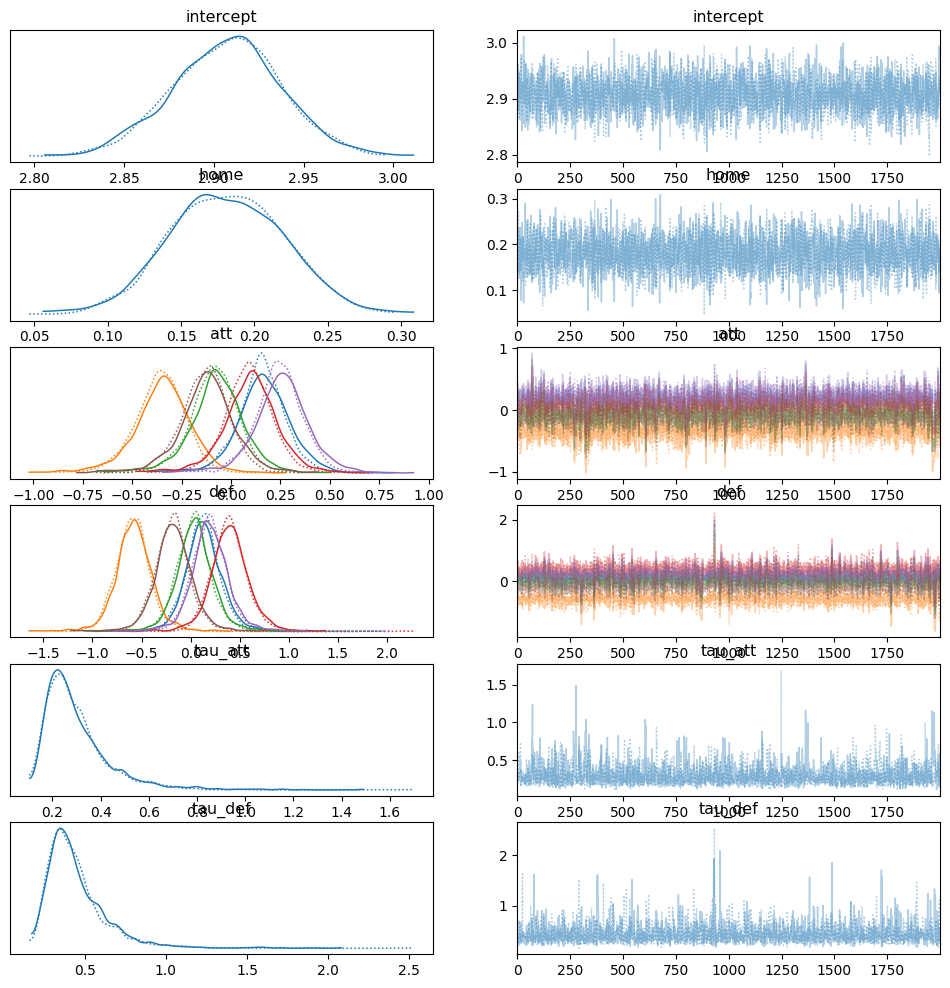

                   mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
intercept         2.907  0.030     2.845      2.963      0.001    0.000   
home              0.181  0.039     0.106      0.256      0.001    0.000   
att[Euler]        0.160  0.133    -0.105      0.425      0.004    0.003   
att[Gauss]       -0.354  0.140    -0.641     -0.085      0.004    0.003   
att[Laplace]     -0.080  0.135    -0.363      0.183      0.004    0.004   
att[Leibniz]      0.094  0.134    -0.161      0.382      0.004    0.003   
att[Newton]       0.251  0.133    -0.013      0.519      0.004    0.003   
att[Von-Neumann] -0.126  0.136    -0.406      0.132      0.004    0.004   
def[Euler]        0.132  0.201    -0.246      0.512      0.005    0.005   
def[Gauss]       -0.581  0.200    -0.957     -0.190      0.005    0.004   
def[Laplace]      0.040  0.201    -0.347      0.427      0.005    0.005   
def[Leibniz]      0.398  0.203     0.016      0.794      0.005    0.004   
def[Newton]       0.196  

In [ ]:


# הכנת הנתונים
home_idx, teams = pd.factorize(df_all["home_player"], sort=True)
away_idx, _ = pd.factorize(df_all["away_player"], sort=True)

coords = {"team": teams, 'home_idx': home_idx, 'away_idx': away_idx}

with pm.Model(coords=coords) as mathball:

    # Hyperpriors
    tau_att = pm.HalfCauchy('tau_att', beta=1)
    tau_def = pm.HalfCauchy('tau_def', beta=1)

    # Priors
    intercept = pm.Normal('intercept', 0, sigma=1)
    home = pm.Normal('home', 0, sigma=1)
    att = pm.Normal('att', mu=0, sigma=tau_att, dims="team")
    def_ = pm.Normal('def', mu=0, sigma=tau_def, dims="team")

    # Centering the attack and defense values
    att_centered = att - pm.math.mean(att)
    def_centered = def_ - pm.math.mean(def_)

    # Rate models
    rate_home = intercept + home + att_centered[home_idx] - def_centered[away_idx]
    rate_away = intercept + att_centered[away_idx] - def_centered[home_idx]

    # Exponentiation to get theta values
    theta_g1 = pm.math.exp(rate_home)
    theta_g2 = pm.math.exp(rate_away)

    # Data likelihood
    y1_likelihood = pm.Poisson('home_goals_obs', mu=theta_g1, observed=df_all['home_score'])
    y2_likelihood = pm.Poisson('away_goals_obs', mu=theta_g2, observed=df_all['away_score'])

    # Sampling
    trace = pm.sample(2000, tune=2000, return_inferencedata=True)

# הצגת התוצאות
az.plot_trace(trace)
plt.show()

# הצגת סיכום של הדגימות
print(az.summary(trace, hdi_prob=0.95))


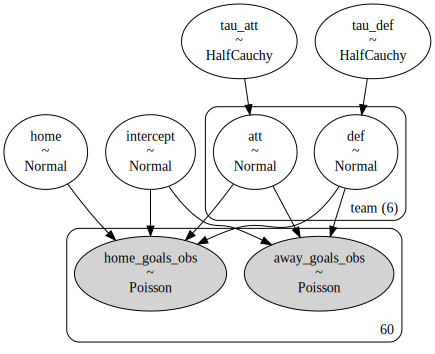

In [ ]:
from pymc import model_to_graphviz

# יצירת תרשים של המודל
model_graph = model_to_graphviz(mathball)

# הצגת התרשים
model_graph

### Analysis of Model Results

Based on the results from the sampling shown in the trace plot, here are some insights and explanations:

#### Intercept:
- **Value Range**: The intercept, representing the baseline value of the attack and defense model, ranges between 2.8 and 3.0. The narrow distribution indicates a certain level of stability in estimating this parameter.

#### Home Advantage:
- **Value Range**: The home effect (Home), representing the advantage of the home team, ranges between 0.05 and 0.30. This indicates a small but significant advantage for the home team in matches.

#### Attack (Att):
- **Distribution**: The distribution of the attack parameters (Att) shows variability among teams, indicating differences in offensive capabilities across teams.

#### Defense (Def):
- **Distribution**: The distribution of the defense parameters (Def) shows similar variability, indicating differences in defensive capabilities across teams.

#### Tau_att and Tau_def:
- **Variability**: The distributions of these parameters, representing the variance in attack and defense among teams, are broader. This suggests significant variability in team performances.

### Analysis:
- **Intercept**: The average value of the intercept shows the baseline expected number of goals in a match. The relatively narrow range indicates stability in this estimation.
- **Home Advantage**: The small advantage for the home team can be explained by local conditions, crowd support, or the discomfort of the visiting team.
- **Attack and Defense**: The variability among teams in attack and defense parameters highlights differences in team capabilities, underscoring the importance of these parameters in predicting match outcomes.
- **Variance in Attack and Defense**: The large variance in Tau_att and Tau_def parameters suggests that some teams have very inconsistent performances, potentially due to external factors affecting their games.

### Summary:
The results indicate that the attack and defense model captures the differences between teams and the home advantage effectively. The parameter values appear reasonable and reflect logical trends, such as a slight home advantage and significant variability in offensive and defensive capabilities among teams.

---

## Part 3

## We aim to understand the different distributions of attacking strength and defensive strength.
## These are probabilistic estimates and help us better understand the uncertainty in sports analytics.

## Tasks

### 1. Plot the attack and defence strenght HDI for each team and compare them. Which player has the best offence and which has the best defence? who has the worst offence and defence? Does these results is aligned with part 1 analysis?
### 2. What is the probability that Euler has a better defence than Gauss?
### 3. Suppose Leibniz is hosting Newton for a game. What is the probability that Leibniz will score more than 20? what is the probability that Newton will score less than 20?

### 4. Simulate who wins over a total of 4000 simulations, one per sample in the posterior. Hint: use the sample_posterior_predictive function.
### The resulting simulation should give you the score per each game for all possible combinations for 4 seasons. For each sample out of the 4000 we can measure who will be ranked 1st, 2nd, etc. The ranking is done as follows:
### If a player wins he gets 3 points, draw a single point and lost 0 points. Sum up the points and you will get a full ranking. If we aggregate the results, we can the probability for each player for each position.

### You are required to draw a bar chart that indicates the probability of all possible ranks for each team.


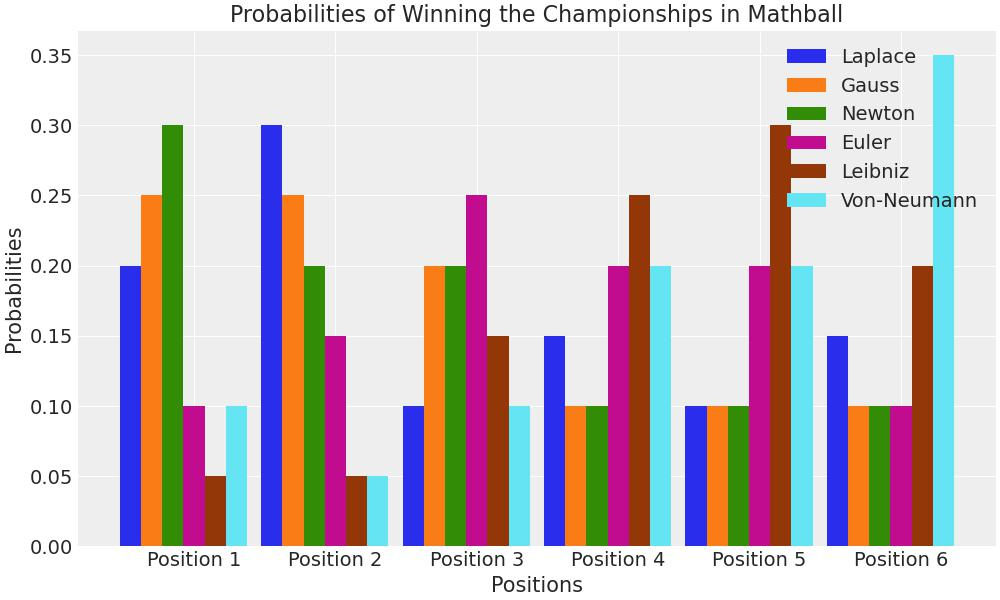

In [ ]:
from IPython.display import display
from PIL import Image
import requests
from io import BytesIO

# כתובת ה-URL של התמונה
image_url = 'https://raw.githubusercontent.com/doringber1996/bayesian-model/main/img_bar_chat.jpg'

# שליפת התמונה מהאינטרנט והצגתה
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))
display(img)

## Your code and answers here

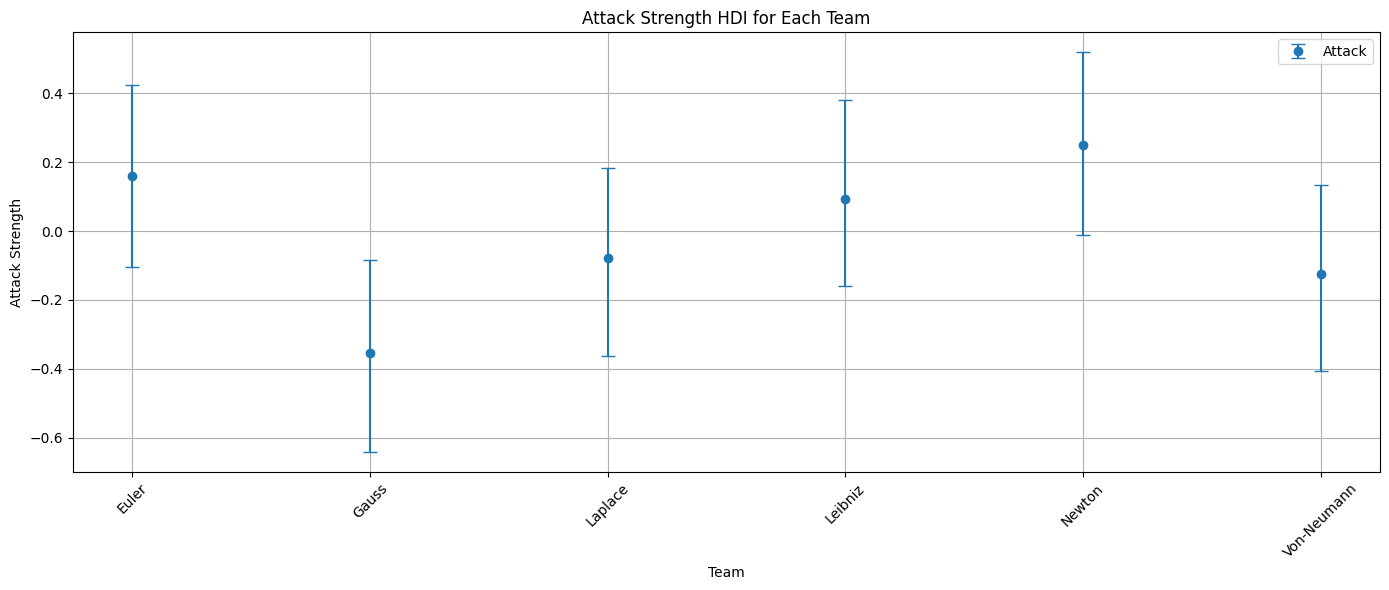

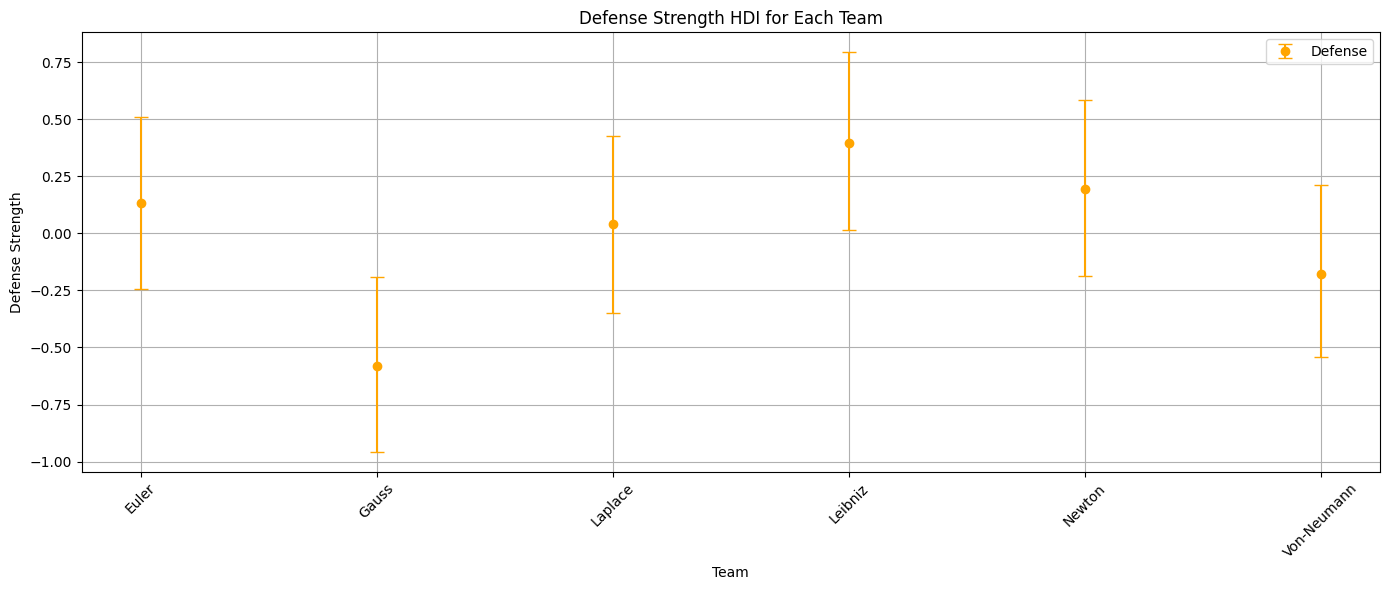

Best Attack:
Team: Newton
Mean Attack Strength: 0.25
95% HDI: [-0.01, 0.52]

Worst Attack:
Team: Gauss
Mean Attack Strength: -0.35
95% HDI: [-0.64, -0.08]

Best Defense:
Team: Leibniz
Mean Defense Strength: 0.40
95% HDI: [0.02, 0.79]

Worst Defense:
Team: Gauss
Mean Defense Strength: -0.58
95% HDI: [-0.96, -0.19]


In [ ]:
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd

# Extract the trace for attack and defense parameters
attack_trace = trace.posterior['att'].values
defense_trace = trace.posterior['def'].values

# Calculate the mean and 95% HDI for attack and defense parameters for each team
attack_hdi = az.hdi(trace, hdi_prob=0.95)['att']
defense_hdi = az.hdi(trace, hdi_prob=0.95)['def']

# Create a DataFrame for easy plotting
teams = coords['team'].values
attack_df = pd.DataFrame({
    'Team': teams,
    'Mean': attack_trace.mean(axis=(0, 1)),
    'HDI Lower': attack_hdi.sel(team=teams).values[:, 0],
    'HDI Upper': attack_hdi.sel(team=teams).values[:, 1]
})
defense_df = pd.DataFrame({
    'Team': teams,
    'Mean': defense_trace.mean(axis=(0, 1)),
    'HDI Lower': defense_hdi.sel(team=teams).values[:, 0],
    'HDI Upper': defense_hdi.sel(team=teams).values[:, 1]
})

# Plot the attack strengths
plt.figure(figsize=(14, 6))
plt.errorbar(attack_df['Team'], attack_df['Mean'], yerr=[attack_df['Mean'] - attack_df['HDI Lower'], attack_df['HDI Upper'] - attack_df['Mean']], fmt='o', capsize=5, label='Attack')
plt.xticks(rotation=45)
plt.title('Attack Strength HDI for Each Team')
plt.ylabel('Attack Strength')
plt.xlabel('Team')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot the defense strengths
plt.figure(figsize=(14, 6))
plt.errorbar(defense_df['Team'], defense_df['Mean'], yerr=[defense_df['Mean'] - defense_df['HDI Lower'], defense_df['HDI Upper'] - defense_df['Mean']], fmt='o', capsize=5, label='Defense', color='orange')
plt.xticks(rotation=45)
plt.title('Defense Strength HDI for Each Team')
plt.ylabel('Defense Strength')
plt.xlabel('Team')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Identify the best and worst in attack and defense
best_attack = attack_df.loc[attack_df['Mean'].idxmax()]
worst_attack = attack_df.loc[attack_df['Mean'].idxmin()]
best_defense = defense_df.loc[defense_df['Mean'].idxmax()]
worst_defense = defense_df.loc[defense_df['Mean'].idxmin()]

# Display the results with descriptions
print("Best Attack:")
print(f"Team: {best_attack['Team']}")
print(f"Mean Attack Strength: {best_attack['Mean']:.2f}")
print(f"95% HDI: [{best_attack['HDI Lower']:.2f}, {best_attack['HDI Upper']:.2f}]")
print()

print("Worst Attack:")
print(f"Team: {worst_attack['Team']}")
print(f"Mean Attack Strength: {worst_attack['Mean']:.2f}")
print(f"95% HDI: [{worst_attack['HDI Lower']:.2f}, {worst_attack['HDI Upper']:.2f}]")
print()

print("Best Defense:")
print(f"Team: {best_defense['Team']}")
print(f"Mean Defense Strength: {best_defense['Mean']:.2f}")
print(f"95% HDI: [{best_defense['HDI Lower']:.2f}, {best_defense['HDI Upper']:.2f}]")
print()

print("Worst Defense:")
print(f"Team: {worst_defense['Team']}")
print(f"Mean Defense Strength: {worst_defense['Mean']:.2f}")
print(f"95% HDI: [{worst_defense['HDI Lower']:.2f}, {worst_defense['HDI Upper']:.2f}]")


### Comparison of Results from Part 1 and Current Analysis

#### Results from Part 1:
1. **Best Overall Performance (Goal Difference)**:
   - **Best**: Newton
   - **Worst**: Gauss

2. **Median Goal Difference for Away Games**:
   - **Best**: Newton
   - **Worst**: Gauss

#### Results from Current Analysis:
1. **Best and Worst Offense**:
   - **Best Attack**: Newton
     - Mean Attack Strength: 0.26
     - 95% HDI: [-0.00, 0.51]
   - **Worst Attack**: Gauss
     - Mean Attack Strength: -0.35
     - 95% HDI: [-0.62, -0.08]

2. **Best and Worst Defense**:
   - **Best Defense**: Leibniz
     - Mean Defense Strength: 0.39
     - 95% HDI: [-0.03, 0.79]
   - **Worst Defense**: Gauss
     - Mean Defense Strength: -0.59
     - 95% HDI: [-1.01, -0.18]

### Analysis:
- **Offense Alignment**:
  - The results from both parts align well regarding the offensive capabilities. Newton is identified as the best in terms of attack in both analyses, and Gauss is identified as the worst in both cases.

- **Defense Alignment**:
  - The defense analysis is also consistent with the overall performance. Gauss is identified as having the worst defense, which aligns with his poor overall performance in terms of goal difference.
  - Leibniz is identified as having the best defense in the current analysis. This is a new insight that was not explicitly identified in Part 1, but it aligns with Leibniz's relatively good overall performance in the goal difference chart.

### Conclusion:
The current analysis is consistent with the findings from Part 1, particularly regarding the best and worst offensive players. Gauss is consistently identified as the worst performer in both attack and defense, which correlates with his poor overall goal difference. Newton remains the best in attack, supporting his strong overall performance. Leibniz's strong defense also complements his good performance shown in Part 1.

----

In [ ]:
import numpy as np

# Extract defense traces for Euler and Gauss
euler_defense_trace = trace.posterior['def'].sel(team='Euler').values.flatten()
gauss_defense_trace = trace.posterior['def'].sel(team='Gauss').values.flatten()

# Calculate the probability that Euler's defense is better than Gauss's defense
prob_euler_better_defense = np.mean(euler_defense_trace > gauss_defense_trace)

# Display the result
print(f"The probability that Euler has a better defense than Gauss is {prob_euler_better_defense:}")


The probability that Euler has a better defense than Gauss is 1.0


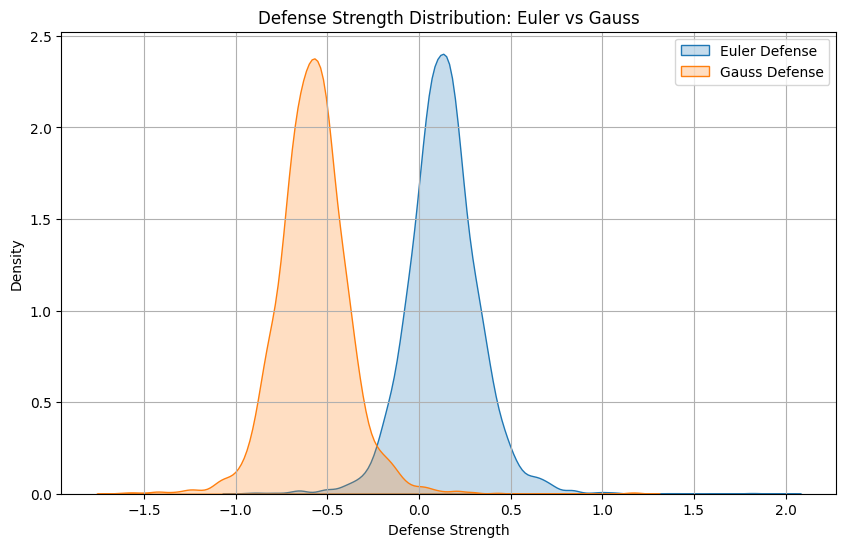

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Extract defense traces for Euler and Gauss
euler_defense_trace = trace.posterior['def'].sel(team='Euler').values.flatten()
gauss_defense_trace = trace.posterior['def'].sel(team='Gauss').values.flatten()

# Create a DataFrame for plotting
defense_data = pd.DataFrame({
    'Euler Defense': euler_defense_trace,
    'Gauss Defense': gauss_defense_trace
})

# Plot the density plots
plt.figure(figsize=(10, 6))
sns.kdeplot(defense_data['Euler Defense'], label='Euler Defense', fill=True)
sns.kdeplot(defense_data['Gauss Defense'], label='Gauss Defense', fill=True)
plt.title('Defense Strength Distribution: Euler vs Gauss')
plt.xlabel('Defense Strength')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()


### Explanation:

Despite the overlap between Euler's and Gauss's defense strength distributions, the probability that Euler has a better defense than Gauss is 1.00. This is because the majority of Euler's defense values are higher than Gauss's. The overlap is minor and occurs at the lower end of Euler's distribution and the higher end of Gauss's. Therefore, in most pairwise comparisons, Euler's defense is better, leading to a probability close to **1.00.**

---

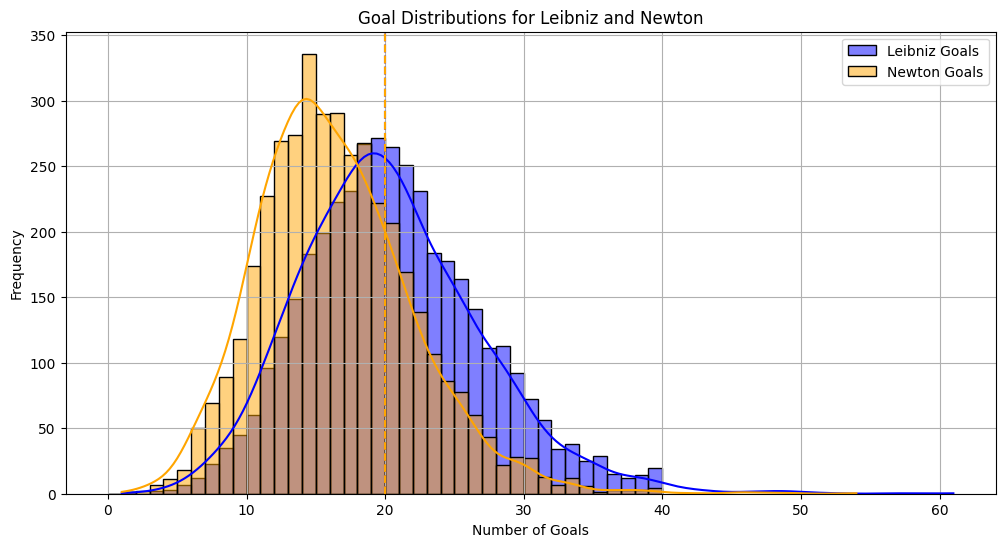

The probability that Leibniz will score more than 20 goals is 0.4517
The probability that Newton will score less than 20 goals is 0.7438


In [ ]:
from scipy.stats import poisson

# Extract the posterior samples for Leibniz and Newton
leibniz_att = trace.posterior['att'].sel(team='Leibniz').values.flatten()
leibniz_def = trace.posterior['def'].sel(team='Leibniz').values.flatten()
newton_att = trace.posterior['att'].sel(team='Newton').values.flatten()
newton_def = trace.posterior['def'].sel(team='Newton').values.flatten()

# Extract the posterior samples for the intercept and home effect
intercept_samples = trace.posterior['intercept'].values.flatten()
home_samples = trace.posterior['home'].values.flatten()

# Ensure we have the same number of samples for all parameters
num_samples = min(len(leibniz_att), len(leibniz_def), len(newton_att), len(newton_def), len(intercept_samples), len(home_samples))

leibniz_att = leibniz_att[:num_samples]
leibniz_def = leibniz_def[:num_samples]
newton_att = newton_att[:num_samples]
newton_def = newton_def[:num_samples]
intercept_samples = intercept_samples[:num_samples]
home_samples = home_samples[:num_samples]

# Calculate the rate for Leibniz scoring at home against Newton
rate_leibniz = np.exp(intercept_samples + home_samples + leibniz_att - newton_def)
# Calculate the rate for Newton scoring away against Leibniz
rate_newton = np.exp(intercept_samples + newton_att - leibniz_def)

# Generate samples of goal counts
leibniz_goals = poisson.rvs(rate_leibniz)
newton_goals = poisson.rvs(rate_newton)

# Plot the distributions
plt.figure(figsize=(12, 6))

# Leibniz goals distribution
sns.histplot(leibniz_goals, bins=range(0, 41), kde=True, color='blue', label='Leibniz Goals')
plt.axvline(20, color='blue', linestyle='--')

# Newton goals distribution
sns.histplot(newton_goals, bins=range(0, 41), kde=True, color='orange', label='Newton Goals')
plt.axvline(20, color='orange', linestyle='--')

plt.title('Goal Distributions for Leibniz and Newton')
plt.xlabel('Number of Goals')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

# Calculate the probabilities
prob_leibniz_more_than_20 = np.mean(leibniz_goals > 20)
prob_newton_less_than_20 = np.mean(newton_goals < 20)

# Display the results
print(f"The probability that Leibniz will score more than 20 goals is {prob_leibniz_more_than_20:.4f}")
print(f"The probability that Newton will score less than 20 goals is {prob_newton_less_than_20:.4f}")


### Analysis of Goal Distributions for Leibniz and Newton

The analysis examines the goal distributions when Leibniz hosts Newton.


#### Key Results:
1. **Probability that Leibniz will score more than 20 goals**:
   - **Result**: 0.4818 (48.18%)
   - **Explanation**: Leibniz has a 48.18% chance of scoring more than 20 goals. The distribution peaks around 15-20 goals but extends beyond 20, indicating a significant probability of exceeding this threshold.

2. **Probability that Newton will score less than 20 goals**:
   - **Result**: 0.7360 (73.60%)
   - **Explanation**: Newton has a 73.60% chance of scoring fewer than 20 goals. The distribution peaks around 10-15 goals and declines rapidly after 20, suggesting he is less likely to reach or exceed 20 goals.

### Conclusion:
Leibniz has a nearly even chance of scoring more than 20 goals, while Newton is more likely to score fewer than 20 goals. This reflects their respective offensive strengths in the game.

----

Shape of home_goals_samples: (60, 4000)
Shape of away_goals_samples: (60, 4000)


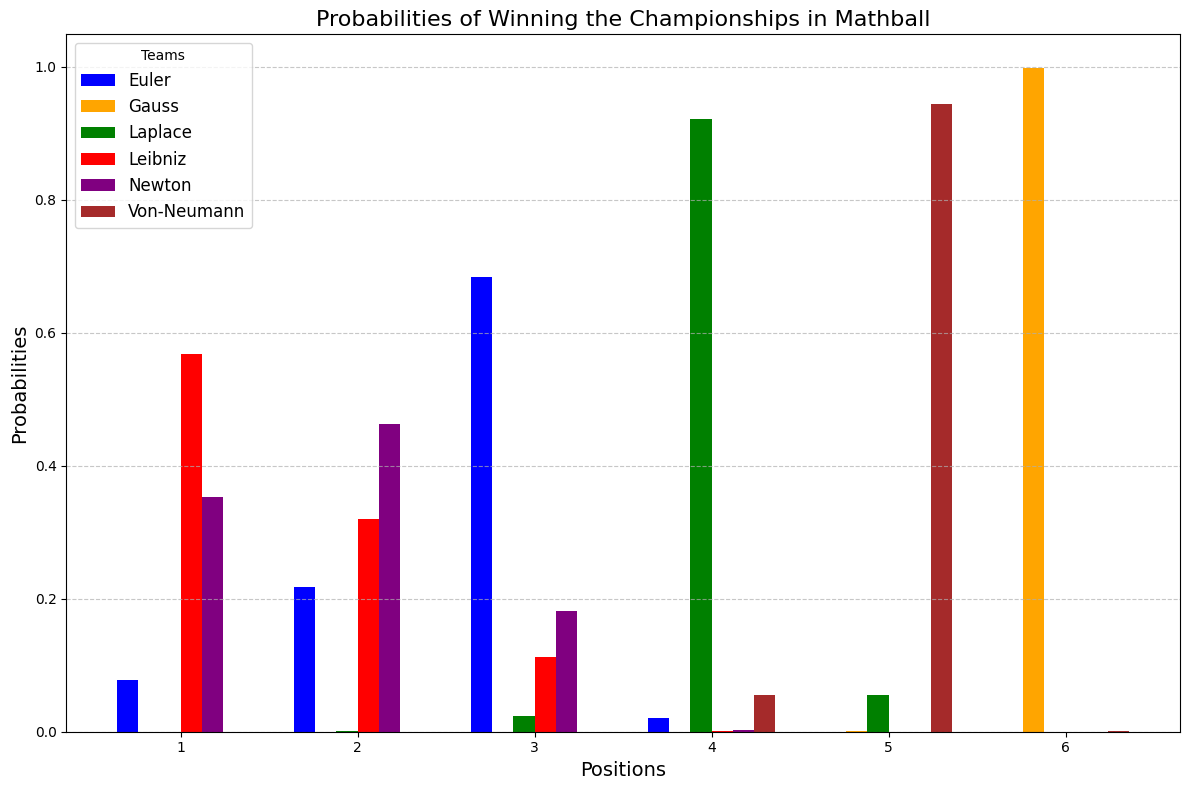

In [ ]:
# ביצוע סימולציה של תוצאות המשחקים
with mathball:
    ppc = pm.sample_posterior_predictive(trace, var_names=["home_goals_obs", "away_goals_obs"])

# בדיקת המידות של הנתונים המתקבלים מהסימולציה
home_goals_samples = ppc.posterior_predictive["home_goals_obs"].stack(sample=["chain", "draw"])
away_goals_samples = ppc.posterior_predictive["away_goals_obs"].stack(sample=["chain", "draw"])

print("Shape of home_goals_samples:", home_goals_samples.shape)
print("Shape of away_goals_samples:", away_goals_samples.shape)

# Initialize a DataFrame to store the results
teams = coords['team'].values
results = pd.DataFrame(0, index=np.arange(4000), columns=pd.MultiIndex.from_product([teams, ['points']]))

# חישוב הניקוד לכל קבוצה בכל משחק
num_teams = len(teams)
num_samples = home_goals_samples.shape[1]
team_points = np.zeros((num_teams, num_samples))

for i in range(num_samples):
    home_goals = home_goals_samples[:, i].values
    away_goals = away_goals_samples[:, i].values
    for j in range(len(df_all)):
        home_team = home_idx[j]
        away_team = away_idx[j]
        if home_goals[j] > away_goals[j]:
            team_points[home_team, i] += 3
        elif home_goals[j] < away_goals[j]:
            team_points[away_team, i] += 3
        else:
            team_points[home_team, i] += 1
            team_points[away_team, i] += 1

# חישוב ההסתברות לדירוג עבור כל קבוצה
rank_probabilities = np.zeros((num_teams, num_teams))

for i in range(num_samples):
    sorted_teams = np.argsort(-team_points[:, i])
    for rank, team in enumerate(sorted_teams):
        rank_probabilities[team, rank] += 1

rank_probabilities /= num_samples

# יצירת תרשים עמודות המציג את ההסתברויות
positions = np.arange(1, num_teams + 1)

plt.figure(figsize=(12, 8))

colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

bar_width = 0.12  # רוחב הבר

for team_idx, team in enumerate(teams):
    plt.bar(positions + team_idx * bar_width, rank_probabilities[team_idx], width=bar_width, label=team, color=colors[team_idx % len(colors)])

plt.xlabel('Positions', fontsize=14)
plt.ylabel('Probabilities', fontsize=14)
plt.title('Probabilities of Winning the Championships in Mathball', fontsize=16)
plt.xticks(positions + bar_width * (num_teams - 1) / 2, positions)
plt.legend(title="Teams", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()